# Cloud Metrics

In [12]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import pdal

from forest_structure_tools.cloud_metrics import height_metrics, percentile_metrics, relative_height_profile_metrics, percent_above, percent_below, percent_in, percent_at


In [13]:
data_dir = Path("../data")
plots_lidar_dir = data_dir / "outputs" / "plots" / "lidar"

In [18]:
def read_plot(plot_id: str):
    file_path = plots_lidar_dir / f"{plot_id}.copc.laz"
    pl = pdal.Reader(str(file_path)).pipeline()
    pl.execute()
    return pl.arrays[0]


def calculate_cloud_metrics(points):
    z = points["Z"]
    rn = points["ReturnNumber"]
    nor = points["NumberOfReturns"]
    weights = 1 / nor

    veg_mask = z > 0
    veg = z[veg_mask]
    veg_weights = weights[veg_mask]

    fr_mask = rn == 1
    fr = z[fr_mask]

    # TODO - Might be better to split this up

    return pd.Series(
        {
            # All Points
            **height_metrics(z),
            **percentile_metrics(z),
            **relative_height_profile_metrics(z),
            **percent_above(z, threshold=1.5),
            **percent_above(z, threshold=1.5, weights=weights, suffix='w'),
            **percent_above(fr, threshold=1, suffix='fr'),
            **percent_at(z, 0),

            # Ground Veg Cover
            **percent_in(z, threshold=(0, 1)),
            **percent_in(z, threshold=(0, 1), weights=weights, suffix='w'),
            **percent_in(fr, threshold=(0, 1),  suffix='fr'),

            # Thresholds
            **percent_in(z, threshold=(50, 100))
        }
    )


def read_and_calculate_cloud_metric(plot_id: str):
    points = read_plot(plot_id)
    metrics = calculate_cloud_metrics(points)
    metrics["id"] = plot_id
    return metrics

In [19]:
read_and_calculate_cloud_metric("AGG_O_01_P1")

max_h                  16.276
min_h                     0.0
range_h                16.276
mean_h               4.428016
median_h                4.555
sd_h                 4.093416
var_h               16.756055
cv_h                 0.924436
p10_h                     0.0
p20_h                     0.0
p30_h                   0.148
p40_h                   1.139
p50_h                   4.555
p60_h                   6.292
p70_h                   7.522
p80_h                   8.656
p90_h                   9.876
%in_[0,10%)         41.262128
%in_[10,20%)         4.245873
%in_[20,30%)         5.987749
%in_[30,40%)        10.160813
%in_[40,50%)        13.707482
%in_[50,60%)         13.84479
%in_[60,70%)         7.758116
%in_[70,80%)         2.427626
%in_[80,90%)         0.543298
%in_[90,100%]        0.062125
%gt_1.5m             59.08965
%gt_1.5m[w]         56.407875
%gt_1m[fr]          84.271453
%at_0m              21.584704
%in_(0,1m]          18.033682
%in_(0,1m][w]       19.187208
%in_(0,1m]

## Parallel Processing

In [19]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58394,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:58407,Total threads: 2
Dashboard: http://127.0.0.1:58411/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:58397,


In [20]:
plots = gpd.read_file(data_dir / "outputs" / "plots" / "plots.geojson")
plot_ids = plots["id"].to_list()

In [21]:
futures = client.map(read_and_calculate_cloud_metric, plot_ids, key=plot_ids)

In [22]:
results = client.gather(futures)

In [23]:
df = pd.DataFrame(results)
df.head()

,max_h,min_h,range_h,mean_h,median_h,sd_h,var_h,cv_h,p10_h,p20_h,...,"dns_50-60%[veg,w]","prp_60-70%[veg,w]","dns_60-70%[veg,w]","prp_70-80%[veg,w]","dns_70-80%[veg,w]","prp_80-90%[veg,w]","dns_80-90%[veg,w]","prp_90-100%[veg,w]","dns_90-100%[veg,w]",id
0,16.276,0.0,16.276,4.428016,4.555,4.093416,16.756055,0.924436,0.000,0.000,...,0.114527,0.119400,0.073364,0.039871,0.024498,0.009290,0.005708,0.001026,0.000630,AGG_O_01_P1
1,17.180,0.0,17.180,4.471003,4.654,4.084572,16.683728,0.913569,0.000,0.000,...,0.108480,0.089533,0.052118,0.027933,0.016260,0.007684,0.004473,0.001293,0.000753,AGG_O_01_P2
2,21.463,0.0,21.463,5.345632,5.666,4.651064,21.632397,0.870068,0.000,0.051,...,0.079660,0.053609,0.024979,0.006595,0.003073,0.000448,0.000209,0.000326,0.000152,AGG_O_01_P3
3,65.734,0.0,65.734,16.257810,9.918,17.180286,295.162213,1.056740,0.169,1.396,...,0.007222,0.061812,0.009403,0.064373,0.009793,0.042329,0.006440,0.007034,0.001070,AGG_O_01_P4
4,73.597,0.0,73.597,20.240314,15.226,18.600699,345.985988,0.918993,0.127,3.078,...,0.006538,0.084450,0.011475,0.057653,0.007834,0.049569,0.006735,0.005359,0.000728,AGG_O_01_P5


In [24]:
df.to_json(data_dir / "outputs" / "plots" / "cloud_metrics.json", orient='records')

In [25]:
client.close()

## Correlation

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
df.head()

,max_h,min_h,range_h,mean_h,median_h,sd_h,var_h,cv_h,p10_h,p20_h,...,"dns_50-60%[veg,w]","prp_60-70%[veg,w]","dns_60-70%[veg,w]","prp_70-80%[veg,w]","dns_70-80%[veg,w]","prp_80-90%[veg,w]","dns_80-90%[veg,w]","prp_90-100%[veg,w]","dns_90-100%[veg,w]",id
0,16.276,0.0,16.276,4.428016,4.555,4.093416,16.756055,0.924436,0.000,0.000,...,0.114527,0.119400,0.073364,0.039871,0.024498,0.009290,0.005708,0.001026,0.000630,AGG_O_01_P1
1,17.180,0.0,17.180,4.471003,4.654,4.084572,16.683728,0.913569,0.000,0.000,...,0.108480,0.089533,0.052118,0.027933,0.016260,0.007684,0.004473,0.001293,0.000753,AGG_O_01_P2
2,21.463,0.0,21.463,5.345632,5.666,4.651064,21.632397,0.870068,0.000,0.051,...,0.079660,0.053609,0.024979,0.006595,0.003073,0.000448,0.000209,0.000326,0.000152,AGG_O_01_P3
3,65.734,0.0,65.734,16.257810,9.918,17.180286,295.162213,1.056740,0.169,1.396,...,0.007222,0.061812,0.009403,0.064373,0.009793,0.042329,0.006440,0.007034,0.001070,AGG_O_01_P4
4,73.597,0.0,73.597,20.240314,15.226,18.600699,345.985988,0.918993,0.127,3.078,...,0.006538,0.084450,0.011475,0.057653,0.007834,0.049569,0.006735,0.005359,0.000728,AGG_O_01_P5


In [30]:
print(df.columns.to_list())

['max_h', 'min_h', 'range_h', 'mean_h', 'median_h', 'sd_h', 'var_h', 'cv_h', 'p10_h', 'p20_h', 'p30_h', 'p40_h', 'p50_h', 'p60_h', 'p70_h', 'p80_h', 'p90_h', 'ground_%', 'above_2m_%', 'prp_0-10%', 'dns_0-10%', 'prp_10-20%', 'dns_10-20%', 'prp_20-30%', 'dns_20-30%', 'prp_30-40%', 'dns_30-40%', 'prp_40-50%', 'dns_40-50%', 'prp_50-60%', 'dns_50-60%', 'prp_60-70%', 'dns_60-70%', 'prp_70-80%', 'dns_70-80%', 'prp_80-90%', 'dns_80-90%', 'prp_90-100%', 'dns_90-100%', 'max_h[veg]', 'min_h[veg]', 'range_h[veg]', 'mean_h[veg]', 'median_h[veg]', 'sd_h[veg]', 'var_h[veg]', 'cv_h[veg]', 'p10_h[veg]', 'p20_h[veg]', 'p30_h[veg]', 'p40_h[veg]', 'p50_h[veg]', 'p60_h[veg]', 'p70_h[veg]', 'p80_h[veg]', 'p90_h[veg]', 'above_2m_%[veg]', 'prp_0-10%[veg]', 'dns_0-10%[veg]', 'prp_10-20%[veg]', 'dns_10-20%[veg]', 'prp_20-30%[veg]', 'dns_20-30%[veg]', 'prp_30-40%[veg]', 'dns_30-40%[veg]', 'prp_40-50%[veg]', 'dns_40-50%[veg]', 'prp_50-60%[veg]', 'dns_50-60%[veg]', 'prp_60-70%[veg]', 'dns_60-70%[veg]', 'prp_70-80%

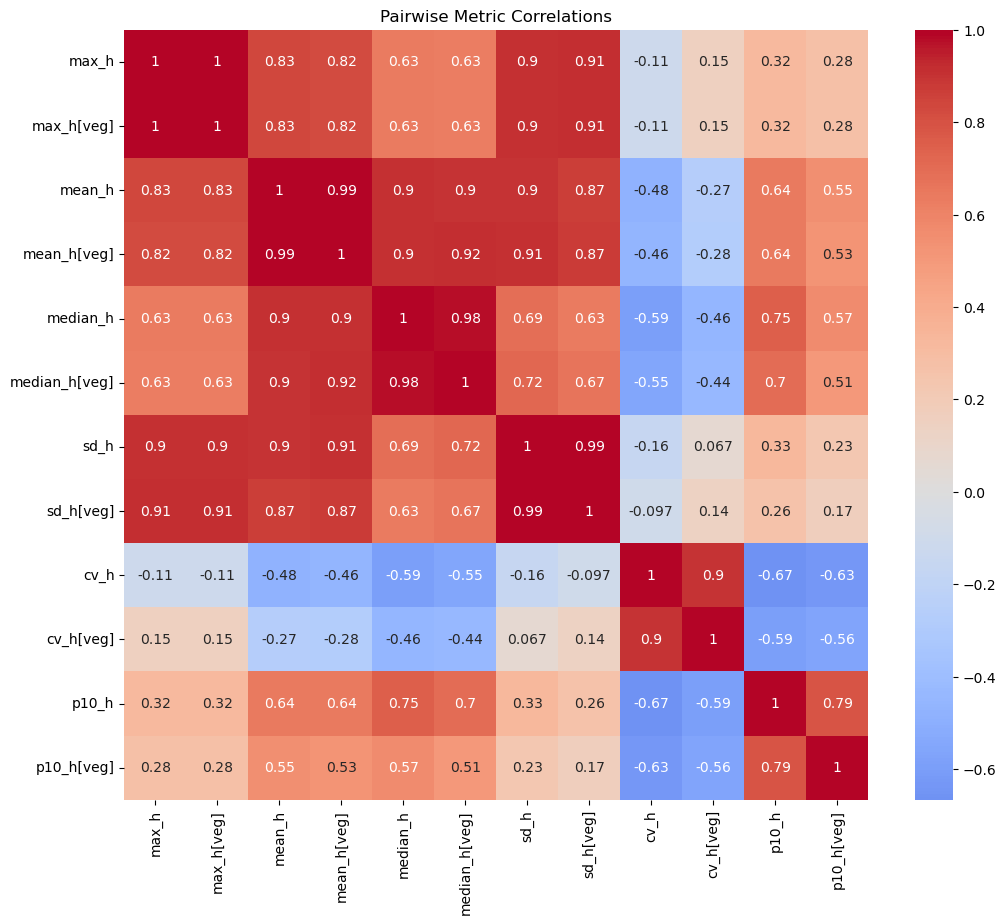

In [ ]:
# Compute correlation matrix
select_metrics = df[['max_h', 'max_h[veg]', 'mean_h', 'mean_h[veg]', 'median_h', 'median_h[veg]', 'sd_h', 'sd_h[veg]', 'cv_h', 'cv_h[veg]', 'p10_h', 'p10_h[veg]']]
corr_matrix = select_metrics.corr(method='pearson')


# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Pairwise Metric Correlations')
plt.show()

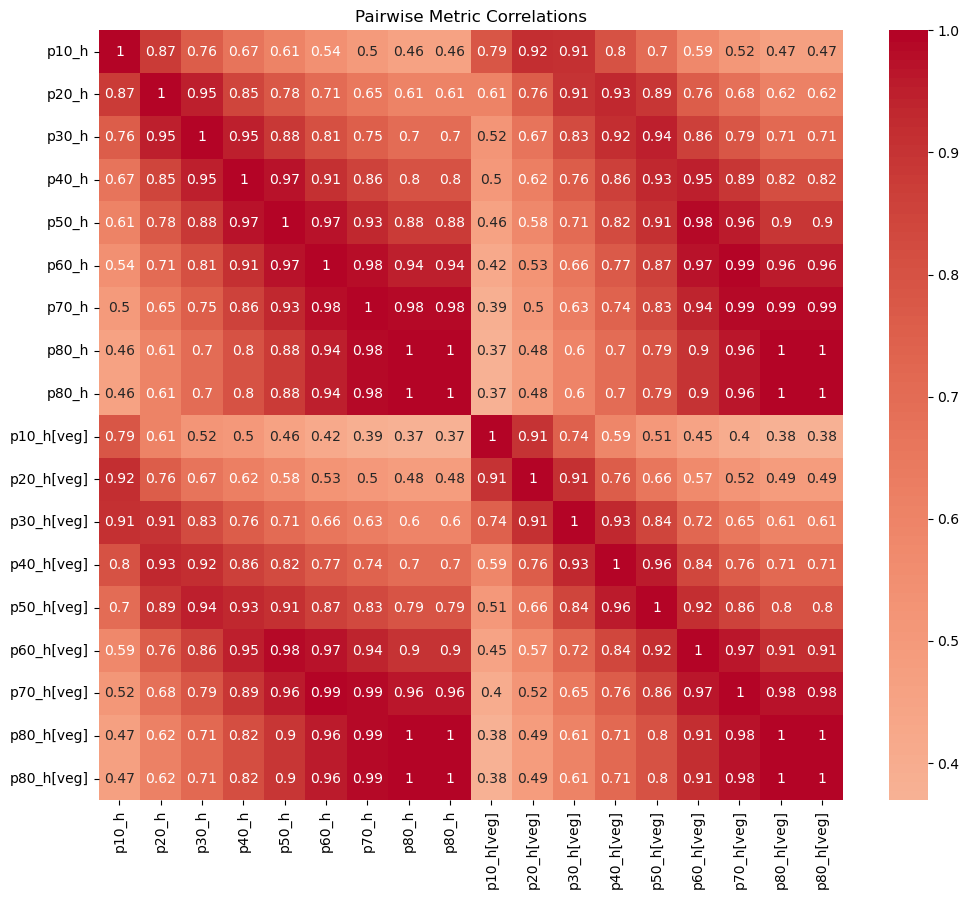

In [83]:
# Compute correlation matrix
ps = [10, 20, 30, 40, 50, 60, 70, 80, 80]
cols = []
for p in ps:
    cols.append(f'p{p}_h')
for p in ps:
    cols.append(f'p{p}_h[veg]')
    # cols.append(f'p{p}_h[veg]')

select_metrics = df[cols]
corr_matrix = select_metrics.corr(method='pearson')


# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Pairwise Metric Correlations')
plt.show()

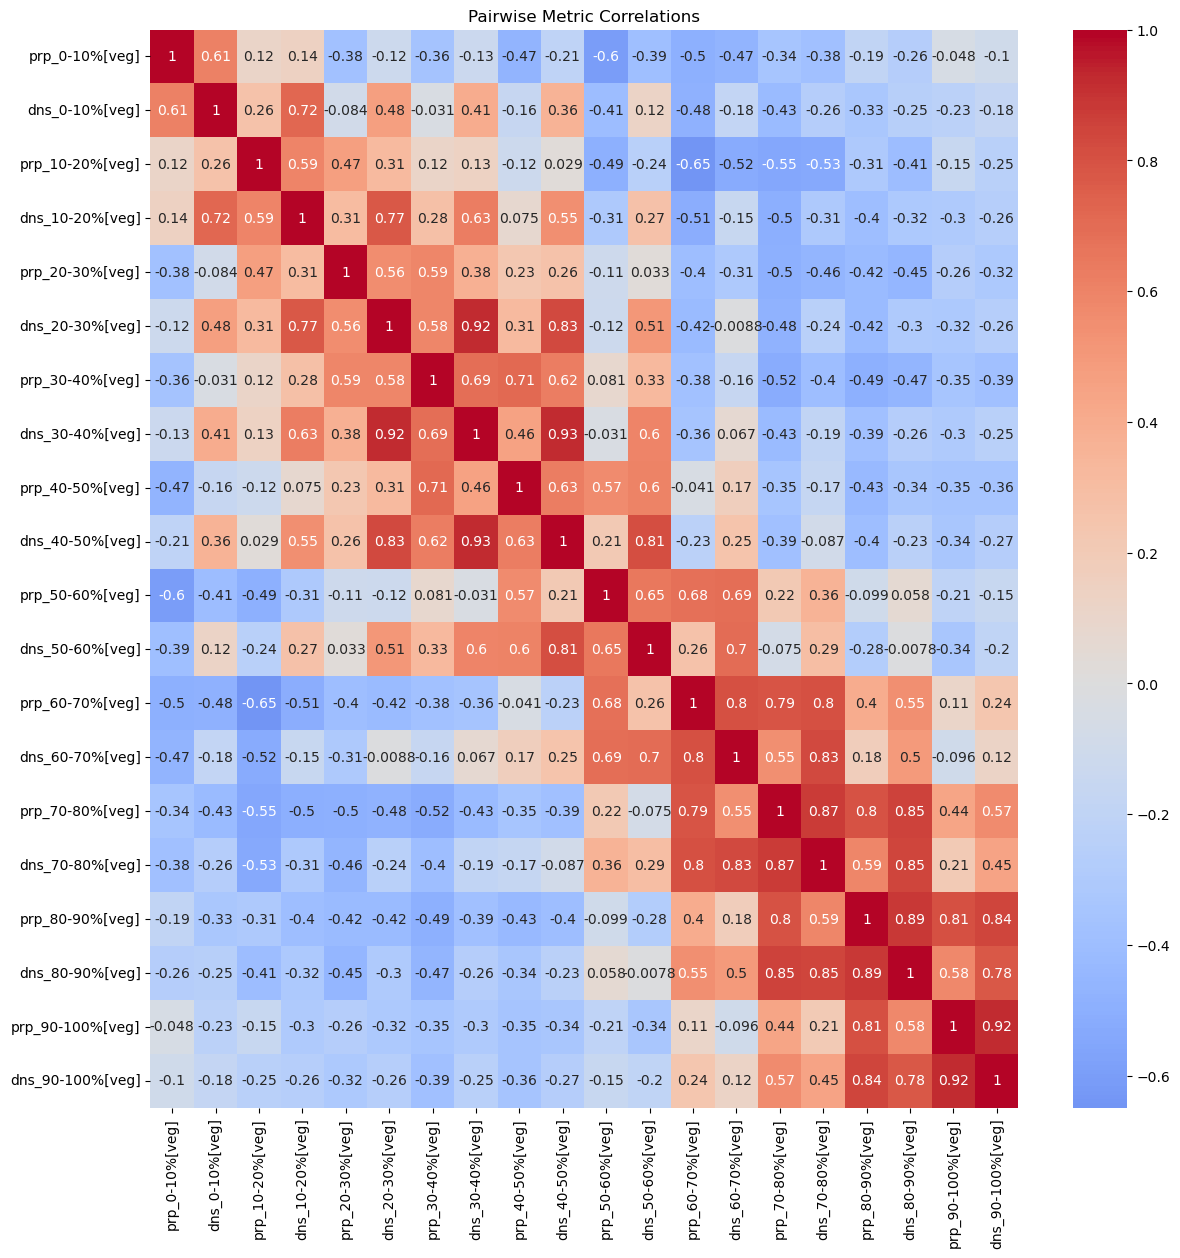

In [32]:
cols = ['prp_0-10%[veg]', 'dns_0-10%[veg]', 'prp_10-20%[veg]', 'dns_10-20%[veg]', 'prp_20-30%[veg]', 'dns_20-30%[veg]', 'prp_30-40%[veg]', 'dns_30-40%[veg]', 'prp_40-50%[veg]', 'dns_40-50%[veg]', 'prp_50-60%[veg]', 'dns_50-60%[veg]', 'prp_60-70%[veg]', 'dns_60-70%[veg]', 'prp_70-80%[veg]', 'dns_70-80%[veg]', 'prp_80-90%[veg]', 'dns_80-90%[veg]', 'prp_90-100%[veg]', 'dns_90-100%[veg]']

select_metrics = df[cols]
corr_matrix = select_metrics.corr(method='pearson')


# Plot heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Pairwise Metric Correlations')
plt.show()